Conditionnal Variational Autoencoder (CVAE) with the Keras Functional API

# Required import

In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape,concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical,plot_model
from scipy.stats import norm

Using TensorFlow backend.


# Load data and processing it

In [2]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()
cat_target_train,cat_target_test=to_categorical(target_train),to_categorical(target_test)
num_label=len(np.unique(target_test))

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
image_size = input_train.shape[1]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)

x_train = np.reshape(input_train, [-1, image_size, image_size, 1])
x_test = np.reshape(input_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (img_height, img_width, num_channels)
label_shape = (num_label,)
# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Model definition VAEs

In [4]:
def sampling(args):
    """Implements reparameterization trick by sampling
    from a gaussian with zero mean and std=1.
    Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    Returns:
        sampled latent vector (tensor)
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# compute the number of labels
num_labels = len(np.unique(y_train))

# network parameters
input_shape = (image_size, image_size, 1)
label_shape = (num_labels, )
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(image_size * image_size)(y_labels)
x = Reshape((image_size, image_size, 1))(x)
x = concatenate([inputs, x])
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs, y_labels],
                [z_mean, z_log_var, z], 
                name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = concatenate([latent_inputs, y_labels])
x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model([latent_inputs, y_labels],
                outputs, 
                name='decoder')
decoder.summary()


# instantiate vae model
outputs = decoder([encoder([inputs, y_labels])[2], y_labels])
cvae = Model([inputs, y_labels], outputs, name='cvae')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 28, 28, 1)    0           dense_4[0][0]                    
____________________________________________________________________________________________

In [45]:
beta=1
reconstruction_loss =  binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * beta
cvae_loss = K.mean(reconstruction_loss + kl_loss)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')
cvae.summary()

TypeError: Failed to convert object of type <class 'function'> to Tensor. Contents: <function cvae_loss at 0x00000228084ED0D8>. Consider casting elements to a supported type.

In [6]:
cvae.fit([x_train, to_categorical(y_train)],
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=([x_test, to_categorical(y_test)], None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 100s 2ms/step - loss: 170.5584 - val_loss: 150.0779
Epoch 2/30
60000/60000 [==============================] - 99s 2ms/step - loss: 145.1965 - val_loss: 142.1042
Epoch 3/30
60000/60000 [==============================] - 100s 2ms/step - loss: 141.3453 - val_loss: 138.7655
Epoch 4/30
60000/60000 [==============================] - 100s 2ms/step - loss: 138.8928 - val_loss: 139.1433
Epoch 5/30
60000/60000 [==============================] - 100s 2ms/step - loss: 137.1287 - val_loss: 136.3550
Epoch 6/30
60000/60000 [==============================] - 100s 2ms/step - loss: 135.8702 - val_loss: 137.3763
Epoch 7/30
60000/60000 [==============================] - 100s 2ms/step - loss: 134.5977 - val_loss: 133.4379
Epoch 8/30
60000/60000 [==============================] - 100s 2ms/step - loss: 133.3641 - val_loss: 132.5414
Epoch 9/30
60000/60000 [==============================] - 101s 2ms/step

In [36]:
import os
model_name = "cvae_cnn_mnist"
save_dir = "cvae_weights"
models=[encoder,decoder]
data=[x_test, y_test]

filename = model_name + '.tf'
filepath = os.path.join(save_dir, filename)
cvae.save_weights(filepath)



CVAE for digit 0


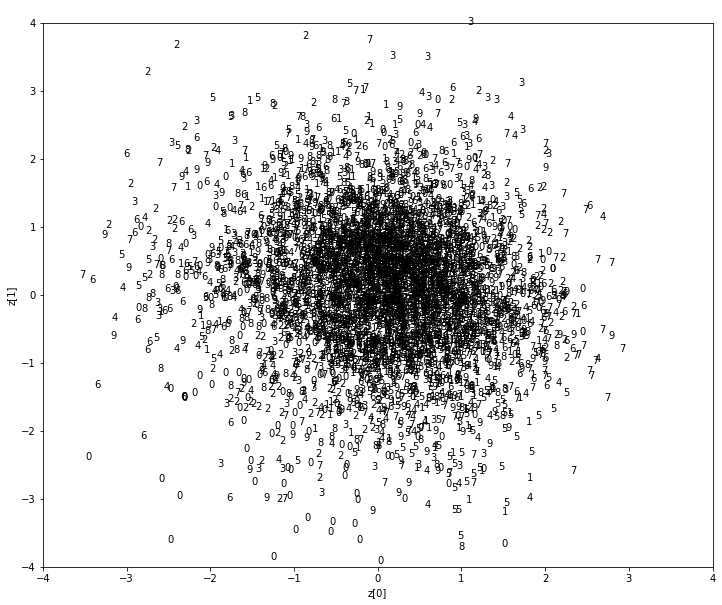

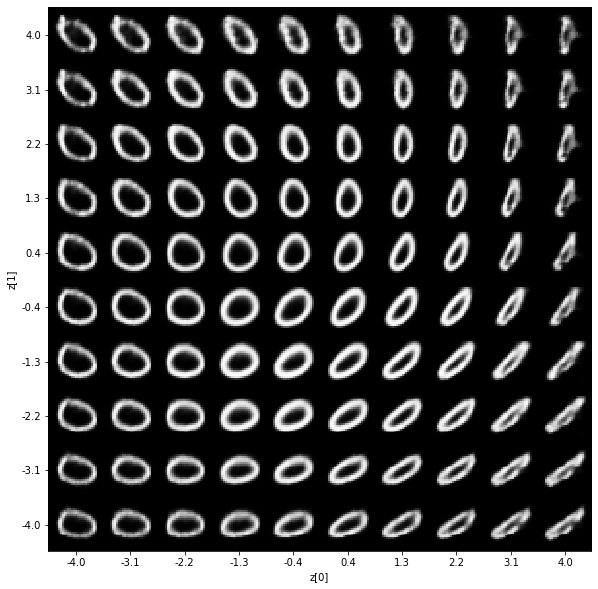

In [39]:
digit = np.random.randint(0, num_labels, 1)

print("CVAE for digit %d" % digit)

y_label = np.eye(num_labels)[digit]

plot_results(models,
             data,
             y_label=y_label,
             batch_size=batch_size,
             model_name=model_name)

In [38]:
def plot_results(models,
                 data,
                 y_label,
                 batch_size=128,
                 model_name="cvae_mnist"):
    """Plots 2-dim mean values of Q(z|X) using labels 
        as color gradient then, plot MNIST digits as 
        function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        y_label (array): one-hot vector of which digit to plot
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict([x_test, to_categorical(y_test)],
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "%05d.png" % np.argmax(y_label))
    # display a 10x10 2D manifold of the digit (y_label)
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict([z_sample, y_label])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [34]:
def viz_latent_space(encoder, data):
    
    input_data, target_data = data
    mu, xi, pi = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(pi[:, 0], pi[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

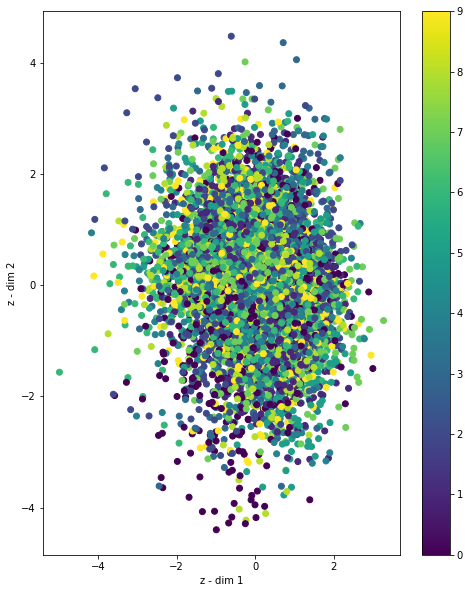

In [35]:
data = [input_test, cat_target_test],target_test
viz_latent_space(encoder, data)